In [1]:
import os
import copy
import functools
import win32com.client

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress, norm
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.fitter import single_siv_ref, two_siv_ref, cavity_ref, three_siv_ref
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
datafolder_path = win32com.client.Dispatch("WScript.Shell").CreateShortCut("../data.lnk").Targetpath
siv_path = datafolder_path + "/20210903_siv_linescan/"

# List of 2-tuples, first is the avg file (which contains the freq values), second is the scans file
siv_files = [["Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt", "Edown_Ndown/linescan_down_down_low-readingtracescans_18_01_33.txt"],  
             ["Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt", "Edown_Ndown_overnight/linescan_downe_downn_low-readingtracescans_10_37_06.txt"],
             ["Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt", "Edown_Nup/linescan_downe_upn_low-readingtracescans_20_49_33.txt"],
             ["Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt", "Eup_Ndown/linescan_upe_downn_low-readingtracescans_22_45_38.txt"],
             ["Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt", "Eup_Nup/linescan_upe_upn_low-readingtracescans_23_49_04.txt"]
            ]

# Plotting SiV

Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt
Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt
Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt
Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt
Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt


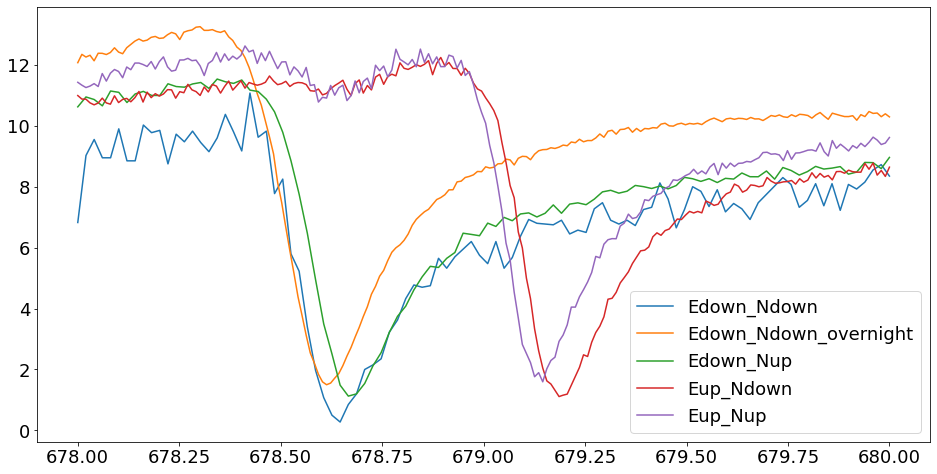

In [3]:
plt.figure(figsize=[16, 8])

for idx, scan_series in enumerate(siv_files):
    
    print(scan_series[0])
    
    siv_freqs = np.loadtxt(siv_path + scan_series[0])
    siv_intensity = np.loadtxt(siv_path + scan_series[1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz

    plt.plot(siv_freqs, siv_intensity_avg, label=scan_series[0].split("/")[0])

plt.legend()

Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt
Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt
Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt
Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt
Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt


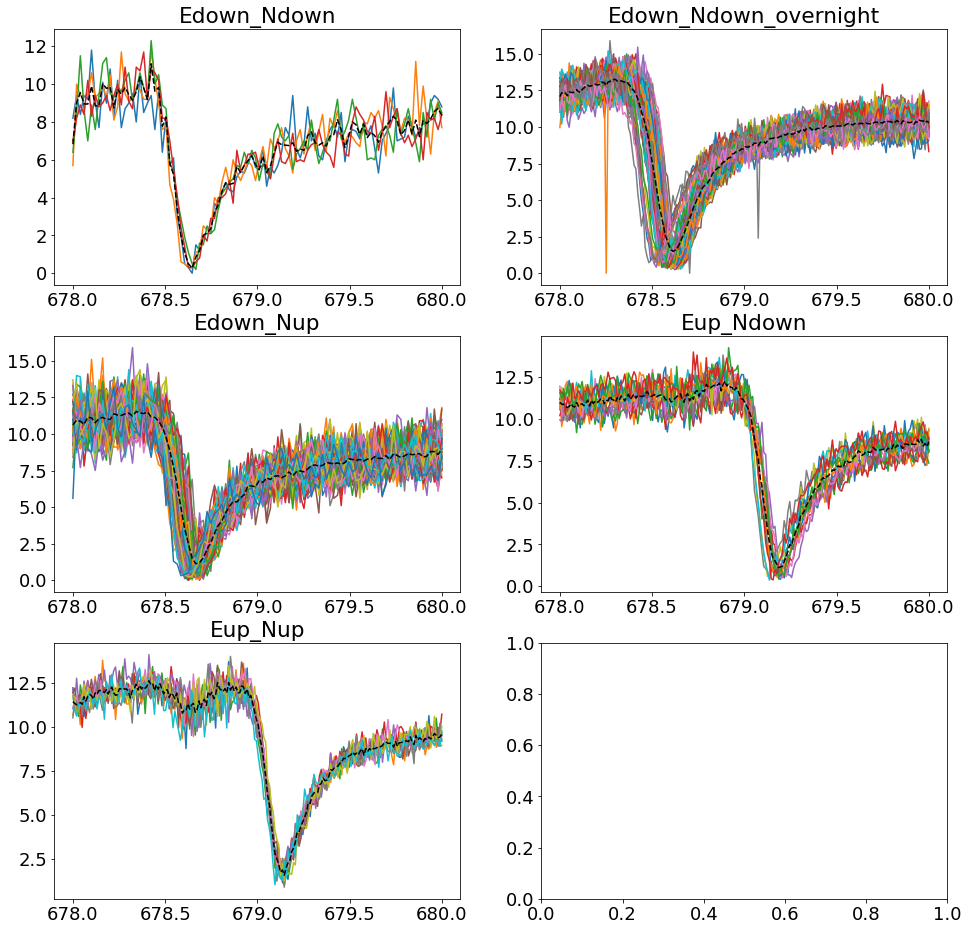

In [4]:
fig, ax = plt.subplots(figsize=[16, 16], ncols=2, nrows=3)
ax = ax.flatten()

for idx, scan_series in enumerate(siv_files):
    
    print(scan_series[0])
    
    siv_freqs = np.loadtxt(siv_path + scan_series[0])
    siv_intensity = np.loadtxt(siv_path + scan_series[1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz

    for scan in siv_intensity:
        ax[idx].plot(siv_freqs, scan)
        
    ax[idx].plot(siv_freqs, siv_intensity_avg, 'k--')
    ax[idx].set_title(scan_series[0].split("/")[0])

Edown_Ndown/linescan_down_down_low-readingtrace_x_18_01_33.txt
Edown_Ndown_overnight/linescan_downe_downn_low-readingtrace_x_10_37_06.txt
Edown_Nup/linescan_downe_upn_low-readingtrace_x_20_49_32.txt


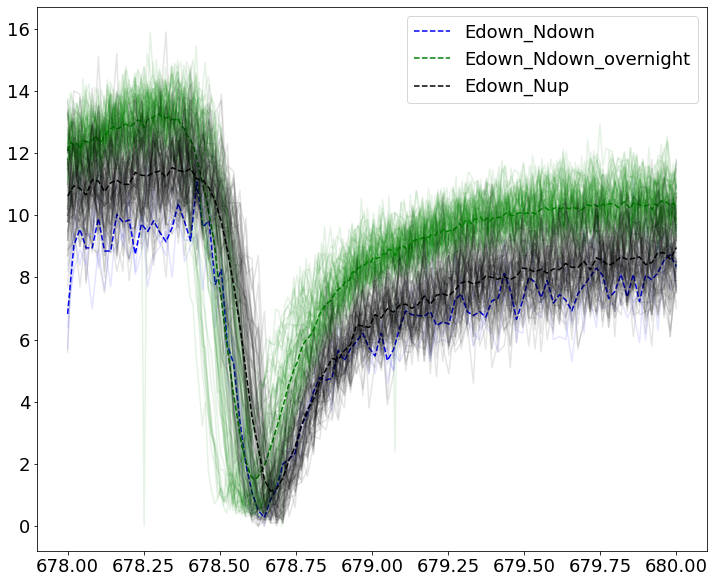

In [5]:
colors = ['b', 'g', 'k']

plt.figure(figsize=[12, 10])
for idx, scan_series in enumerate(siv_files[:3]):
    
    print(scan_series[0])
    
    siv_freqs = np.loadtxt(siv_path + scan_series[0])
    siv_intensity = np.loadtxt(siv_path + scan_series[1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz

    for scan in siv_intensity:
        plt.plot(siv_freqs, scan, c=colors[idx], alpha=0.1)
        
    plt.plot(siv_freqs, siv_intensity_avg, c=colors[idx], ls='--', label=scan_series[0].split("/")[0])

plt.legend()

Eup_Ndown/linescan_upe_downn_low-readingtrace_x_22_45_37.txt
Eup_Nup/linescan_upe_upn_low-readingtrace_x_23_49_04.txt


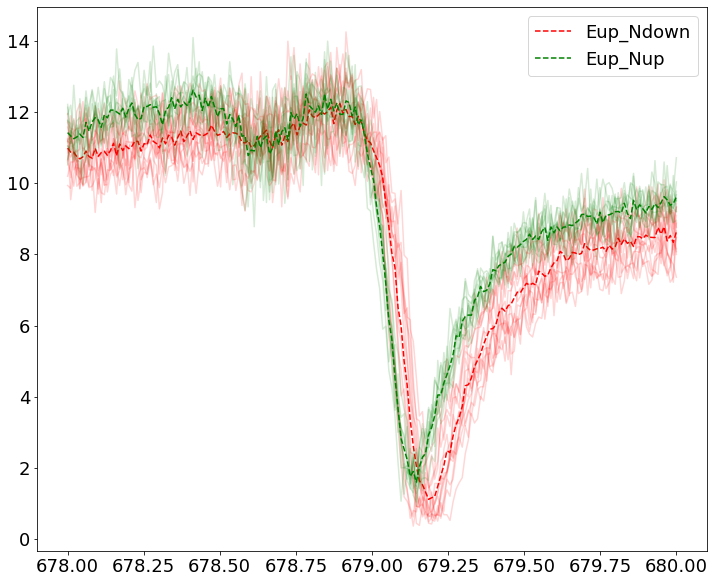

In [6]:
colors = ['r', 'g', 'b']

plt.figure(figsize=[12, 10])
for idx, scan_series in enumerate(siv_files[3:]):
    
    print(scan_series[0])
    
    siv_freqs = np.loadtxt(siv_path + scan_series[0])
    siv_intensity = np.loadtxt(siv_path + scan_series[1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz

    for scan in siv_intensity:
        plt.plot(siv_freqs, scan, c=colors[idx], alpha=0.16)
        
    plt.plot(siv_freqs, siv_intensity_avg, c=colors[idx], ls='--', label=scan_series[0].split("/")[0])

plt.legend()

# E-Up, N-Up

## Fix w_c, vary k_tot

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 366
    # data points      = 200
    # variables        = 5
    chi-square         = 31.7673721
    reduced chi-square = 0.16290960
    Akaike info crit   = -357.975527
    Bayesian info crit = -341.483941
[[Variables]]
    w_up:      679.073047 +/- 0.00238064 (0.00%) (init = 679.2)
    g_up:      3.97834622 +/- 0.06316908 (1.59%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       610 (fixed)
    k_in:      177.855471 +/- 6.38660030 (3.59%) (init = 29)
    k_tot:     236.621420 +/- 9.77245278 (4.13%) (init = 46)
    A:         34.3417006 +/- 1.48285400 (4.32%) (init = 10)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.991
    C(k_tot, A)    =  0.882
    C(k_in, A)     =  0.812
    C(g_up, k_in)  =  0.413
    C(g_up, k_tot) =  0.316
    C(w_up, k_in)  =  0.231
    C(w_up, g_up)  = -0.226
    C(w_up, k_tot) =  0.206
    C(w_up, A)     =  0.107


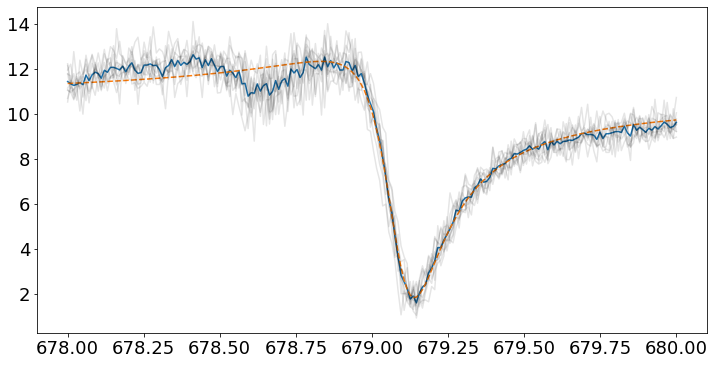

In [14]:
scan_index = 4

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)

###############

params = Parameters()
params.add_many(
    Parameter('w_up', value=679.2, min=678.8, max=679.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=29, min=10, max=356),
    Parameter('k_tot', value=46, min=10, max=356),
    Parameter('A', value=10, min=1, max=40),
    Parameter('B', value=0, vary=False),
)

up_up_results = single_siv_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(up_up_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, single_siv_ref_model.eval(up_up_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

## Fix k_tot, vary w_c

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 426
    # data points      = 200
    # variables        = 5
    chi-square         = 31.1414246
    reduced chi-square = 0.15969961
    Akaike info crit   = -361.955691
    Bayesian info crit = -345.464104
[[Variables]]
    w_up:      678.995234 +/- 0.00637332 (0.00%) (init = 679.2)
    g_up:      5.04017163 +/- 0.21112984 (4.19%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       492.099370 +/- 6.58208428 (1.34%) (init = 610)
    k_in:      60.4540251 +/- 1.68722526 (2.79%) (init = 70)
    k_tot:     120 (fixed)
    A:         15.1056939 +/- 0.28051237 (1.86%) (init = 10)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(w_c, A)     =  0.986
    C(g_up, w_c)  = -0.968
    C(g_up, A)    = -0.961
    C(w_up, g_up) = -0.926
    C(w_up, k_in) =  0.853
    C(w_up, A)    =  0.837
    C(w_up, w_c)  =  0.829
    C(g_up, k_in) = -0.727
    C(k_in, A)    =  0.657
    C(w_c, k_i

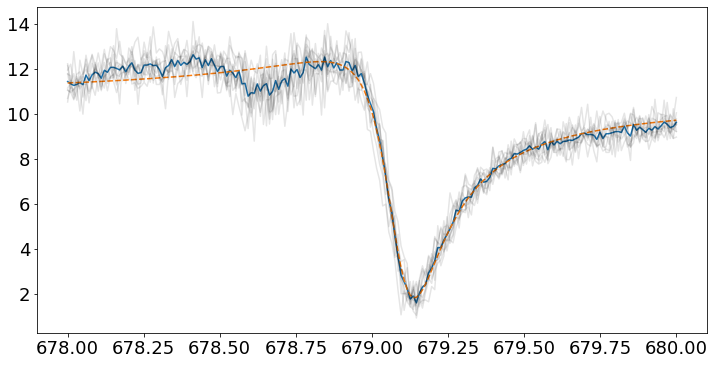

In [15]:
scan_index = 4

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)

###############

params = Parameters()
params.add_many(
    Parameter('w_up', value=679.2, min=678.8, max=679.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=610, min=400, max=800),
    Parameter('k_in', value=70, min=10, max=356),
    Parameter('k_tot', value=120, vary=False),
    Parameter('A', value=10, min=1, max=40),
    Parameter('B', value=0, vary=False),
)

up_up_results = single_siv_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(up_up_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, single_siv_ref_model.eval(up_up_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

## Fix k_tot, fix w_c

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 190
    # data points      = 200
    # variables        = 4
    chi-square         = 61.6319001
    reduced chi-square = 0.31444847
    Akaike info crit   = -227.427554
    Bayesian info crit = -214.234285
[[Variables]]
    w_up:      679.069561 +/- 0.00386810 (0.00%) (init = 679.2)
    g_up:      3.22575406 +/- 0.19697847 (6.11%) (init = 5.6)
    gamma_up:  0.05 (fixed)
    w_c:       610 (fixed)
    k_in:      100.267177 +/- 1.84815307 (1.84%) (init = 70)
    k_tot:     129 (fixed)
    A:         23.5981025 +/- 1.12337501 (4.76%) (init = 10)
    B:         0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, A)    = -0.996
    C(g_up, k_in) =  0.960
    C(g_up, A)    = -0.958
    C(w_up, g_up) = -0.720
    C(w_up, A)    =  0.554
    C(w_up, k_in) = -0.553


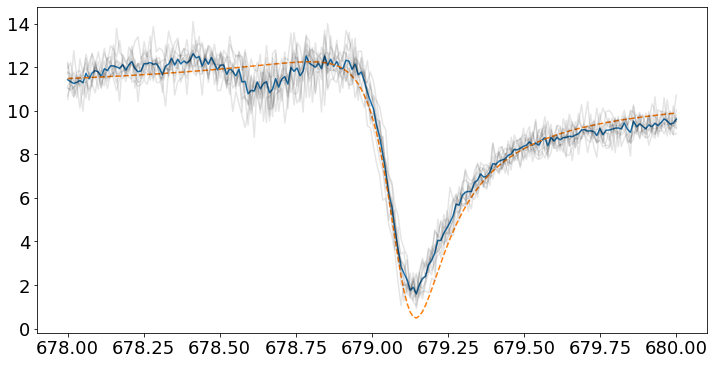

In [9]:
scan_index = 4

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)

###############

params = Parameters()
params.add_many(
    Parameter('w_up', value=679.2, min=678.8, max=679.5),
    Parameter('g_up', value=5.6, min=1, max=20),
    Parameter('gamma_up', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=70, min=10, max=356),
    Parameter('k_tot', value=129, vary=False),
    Parameter('A', value=10, min=1, max=40),
    Parameter('B', value=0, vary=False),
)

up_up_results = single_siv_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(up_up_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, single_siv_ref_model.eval(up_up_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

## Two-State Fitting

In [10]:
# Consider using diffusion to blur the output
spectral_diffusion = 0.03

# Sample within 2 stdev
delta_lst = np.linspace(-2*spectral_diffusion, 2*spectral_diffusion, 21)

# Weigh using a normalized Gaussian
normal_pdf = np.array([norm.pdf(delta, 0, spectral_diffusion) for delta in delta_lst])
normal_pdf /= sum(normal_pdf) 

def two_siv_mixed_ref(w, w_up_1, g_up_1, gamma_up_1, w_up_2, g_up_2, gamma_up_2, w_c, k_in, k_tot, A, B):
    
    def ref(w):
        return A * Cavity.reflectance_fn(w, 1,
            [{"w_up": w_up_1, "g_up": g_up_1, "gamma_up": gamma_up_1}],
            w_c, k_in, k_tot) + B * Cavity.reflectance_fn(w, 1,
            [{"w_up": w_up_2, "g_up": g_up_2, "gamma_up": gamma_up_2}],
            w_c, k_in, k_tot)
    
    # Use diffusion to blur the output
    diffused_output = np.array([ref(w + delta) for delta in delta_lst])
    convolved_output = np.sum([diffused_output[i] * normal_pdf[i] for i in range(len(normal_pdf))], axis=0)
    
    return convolved_output

two_siv_mixed_ref_model = lmfit.Model(two_siv_mixed_ref)

## Fix k_tot, fix w_c

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 1168
    # data points      = 200
    # variables        = 7
    chi-square         = 8.11555380
    reduced chi-square = 0.04204950
    Akaike info crit   = -626.906985
    Bayesian info crit = -603.818763
[[Variables]]
    w_up_1:      679.055391 +/- 0.00159579 (0.00%) (init = 679.2)
    g_up_1:      2.79207300 +/- 0.05867661 (2.10%) (init = 5.6)
    gamma_up_1:  0.05 (fixed)
    w_up_2:      678.555084 +/- 0.00949549 (0.00%) (init = 678.5)
    g_up_2:      3.01408516 +/- 0.14958582 (4.96%) (init = 5.6)
    gamma_up_2:  0.05 (fixed)
    w_c:         610 (fixed)
    k_in:        89.6429792 +/- 0.68493060 (0.76%) (init = 70)
    k_tot:       129 (fixed)
    A:           27.0891485 +/- 0.55926355 (2.06%) (init = 10)
    B:           4.41535903 +/- 0.17721043 (4.01%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_up_1, A)      = -0.971
    C(k_in, A)        = -0.949
    C(g_up_1, k_in

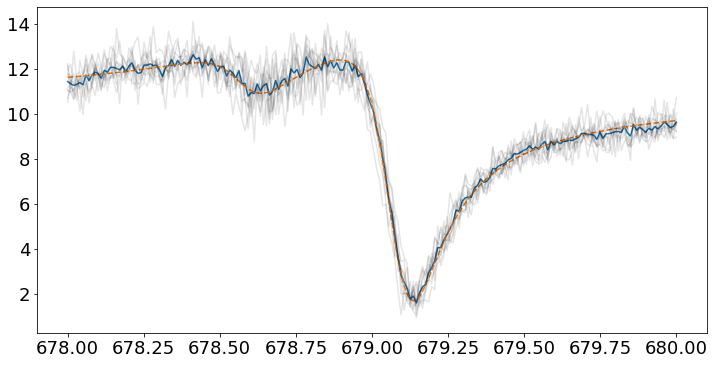

In [20]:
scan_index = 4

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)

###############

params = Parameters()
params.add_many(
    Parameter('w_up_1', value=679.2, min=678.8, max=679.5),
    Parameter('g_up_1', value=5.6, min=0.1, max=20),
    Parameter('gamma_up_1', value=0.05, vary=False),
    Parameter('w_up_2', value=678.5, min=678.4, max=678.8),
    Parameter('g_up_2', value=5.6, min=0.1, max=20),
    Parameter('gamma_up_2', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=70, min=10, max=356),
    Parameter('k_tot', value=129, vary=False),
    Parameter('A', value=10, min=1, max=40),
    Parameter('B', value=1, min=0.01, max=5),
)

up_up_results = two_siv_mixed_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(up_up_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, two_siv_mixed_ref_model.eval(up_up_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

## Fix k_tot, vary w_c

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 1314
    # data points      = 200
    # variables        = 8
    chi-square         = 7.11121297
    reduced chi-square = 0.03703757
    Akaike info crit   = -651.328907
    Bayesian info crit = -624.942369
[[Variables]]
    w_up_1:      679.039196 +/- 0.00290170 (0.00%) (init = 679.2)
    g_up_1:      3.24780906 +/- 0.10395443 (3.20%) (init = 5.6)
    gamma_up_1:  0.05 (fixed)
    w_up_2:      678.515243 +/- 0.01220857 (0.00%) (init = 678.5)
    g_up_2:      4.05916015 +/- 0.25182043 (6.20%) (init = 5.6)
    gamma_up_2:  0.05 (fixed)
    w_c:         568.049265 +/- 4.92477449 (0.87%) (init = 610)
    k_in:        80.9535738 +/- 1.15031129 (1.42%) (init = 29)
    k_tot:       129 (fixed)
    A:           20.3876043 +/- 0.70628661 (3.46%) (init = 10)
    B:           2.72324491 +/- 0.19036498 (6.99%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(g_up_1, A)      = -0.990
    C(w_c, A) 

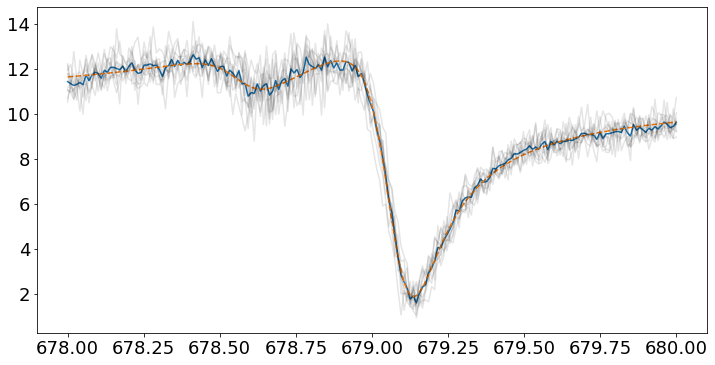

In [19]:
scan_index = 4

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)

###############

params = Parameters()
params.add_many(
    Parameter('w_up_1', value=679.2, min=678.8, max=679.5),
    Parameter('g_up_1', value=5.6, min=0.1, max=20),
    Parameter('gamma_up_1', value=0.05, vary=False),
    Parameter('w_up_2', value=678.5, min=678.4, max=678.8),
    Parameter('g_up_2', value=5.6, min=0.1, max=20),
    Parameter('gamma_up_2', value=0.05, vary=False),
    Parameter('w_c', value=610, min=400, max=800),
    Parameter('k_in', value=29, min=10, max=356),
    Parameter('k_tot', value=129, vary=False),
    Parameter('A', value=10, min=1, max=40),
    Parameter('B', value=1, min=0.01, max=5),
)

up_up_results = two_siv_mixed_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(up_up_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, two_siv_mixed_ref_model.eval(up_up_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

## Fix w_c, vary k_tot

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 1125
    # data points      = 200
    # variables        = 8
    chi-square         = 7.39829670
    reduced chi-square = 0.03853280
    Akaike info crit   = -643.413514
    Bayesian info crit = -617.026975
[[Variables]]
    w_up_1:      679.038365 +/- 0.00310930 (0.00%) (init = 679.2)
    g_up_1:      2.55675719 +/- 0.03794634 (1.48%) (init = 5.6)
    gamma_up_1:  0.05 (fixed)
    w_up_2:      678.506178 +/- 0.01296390 (0.00%) (init = 678.5)
    g_up_2:      3.35338564 +/- 0.19261304 (5.74%) (init = 5.6)
    gamma_up_2:  0.05 (fixed)
    w_c:         610 (fixed)
    k_in:        49.9705478 +/- 2.90495319 (5.81%) (init = 70)
    k_tot:       80.3532378 +/- 3.62847181 (4.52%) (init = 120)
    A:           20.5495555 +/- 0.73844074 (3.59%) (init = 10)
    B:           2.73192002 +/- 0.18730349 (6.86%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot)    =  0.988
    C(k_tot, A

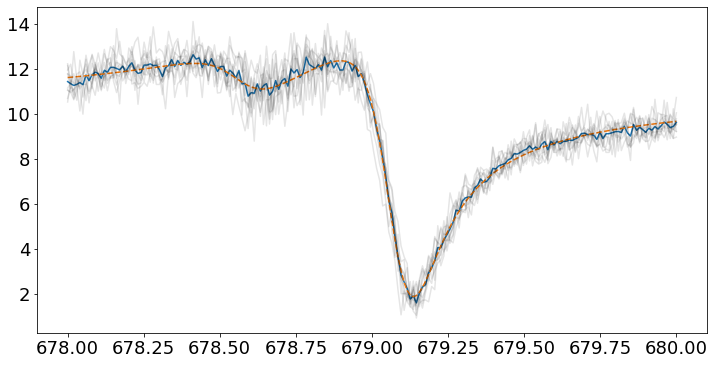

In [18]:
scan_index = 4

siv_freqs = np.loadtxt(siv_path + siv_files[scan_index][0])
siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
siv_intensity = np.loadtxt(siv_path + siv_files[scan_index][1])
siv_intensity_avg = np.mean(siv_intensity, axis=0)

###############

params = Parameters()
params.add_many(
    Parameter('w_up_1', value=679.2, min=678.8, max=679.5),
    Parameter('g_up_1', value=5.6, min=0.1, max=20),
    Parameter('gamma_up_1', value=0.05, vary=False),
    Parameter('w_up_2', value=678.5, min=678.4, max=678.8),
    Parameter('g_up_2', value=5.6, min=0.1, max=20),
    Parameter('gamma_up_2', value=0.05, vary=False),
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=70, min=10, max=356),
    Parameter('k_tot', value=120, min=10, max=356),
    Parameter('A', value=10, min=1, max=40),
    Parameter('B', value=1, min=0.01, max=5),
)

up_up_results = two_siv_mixed_ref_model.fit(siv_intensity_avg, params, w=siv_freqs, method="lbfgsb")
lmfit.report_fit(up_up_results)

plt.figure(figsize=[12, 6])
plt.plot(siv_freqs, siv_intensity_avg)
plt.plot(siv_freqs, two_siv_mixed_ref_model.eval(up_up_results.params, w=siv_freqs), '--')
for scan in siv_intensity:
    plt.plot(siv_freqs, scan, c='k', alpha=0.1)

In [92]:
# Consider using diffusion to blur the output
# Each scan has a different diffusion stdev
# spectral_diffusions = np.array([44.8, 31.9, 16.5, 46.6]) / 1000
spectral_diffusions = np.array([30] * 4) / 1000

delta_lsts = []
normal_pdfs = []

for spectral_diffusion in spectral_diffusions:
    # Sample within 2 stdev
    delta_lst = np.linspace(-2*spectral_diffusion, 2*spectral_diffusion, 21)

    # Weigh using a normalized Gaussian
    normal_pdf = np.array([norm.pdf(delta, 0, spectral_diffusion) for delta in delta_lst])
    normal_pdf /= sum(normal_pdf) 

    delta_lsts.append(delta_lst)
    normal_pdfs.append(normal_pdf)

def get_val_from_model(params, state_idx, model, w):   
    w_c = params["w_c"]
    k_in = params["k_in"]
    k_tot = params["k_tot"]
    gamma_up = params[f"gamma_up"]
    
    A = params[f"A_state{state_idx}"]
    B = params[f"B_state{state_idx}"]
    
    # Indices of the stronger followed by weaker peak
    # Pair up the states with same nuclear but opposite electronic spin
    pair_indices = {
        0: (0, 2),
        1: (1, 3),
        2: (2, 0),
        3: (3, 1)
    }
    strong_idx, weak_idx = pair_indices[state_idx]
    
    w_up_1 = params[f"w_up_state{strong_idx}"]
    w_up_2 = params[f"w_up_state{weak_idx}"]
    g_up_1 = params[f"g_up_state{strong_idx}"]
    g_up_2 = params[f"g_up_state{weak_idx}"]
    
    args = [w_up_1, g_up_1, gamma_up, 
            w_up_2, g_up_2, gamma_up, 
            w_c, k_in, k_tot, A, B]
    
    delta_lst = delta_lsts[state_idx]
    normal_pdf = normal_pdfs[state_idx]
    
    # Use diffusion to blur the output
    diffused_output = np.array([model(w + delta, *args) for delta in delta_lst])
    convolved_output = np.sum([diffused_output[i] * normal_pdf[i] for i in range(len(normal_pdf))], axis=0)
    
    return convolved_output
#     return model(w, *args)

def objective(params, freqs_lst, data_lst, model_list):
    residuals_lst = np.array([])
    
    for state_idx in range(len(data_lst)):
        
        freqs = freqs_lst[state_idx]
        data = data_lst[state_idx]
        model = model_list[state_idx]

        residual = data - get_val_from_model(params, state_idx, model, freqs)
        residuals_lst = np.append(residuals_lst, residual)

    return residuals_lst

def collect_folder_data(folder_idx, file_list):

    siv_freqs = np.loadtxt(siv_path + file_list[folder_idx][0])
    siv_freqs = 1000 * (siv_freqs - 406) # Re-center, convert to GHz
    siv_intensity = np.loadtxt(siv_path + file_list[folder_idx][1])
    siv_intensity_avg = np.mean(siv_intensity, axis=0)

    return siv_freqs, siv_intensity_avg

def fit_combined_data(fit_params, objective, model_list, file_list):
            
    siv_freqs_list = []
    siv_data_list = []
    
    for state_idx in range(len(file_list)):
        
        siv_freqs, siv_data = collect_folder_data(state_idx, file_list)
        siv_freqs_list.append(siv_freqs)
        siv_data_list.append(siv_data)

    out = lmfit.minimize(objective, fit_params, 
                         args=(siv_freqs_list, siv_data_list, model_list))#, method="lbfgsb")
    return out

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 166
    # data points      = 700
    # variables        = 17
    chi-square         = 24.7044180
    reduced chi-square = 0.03617045
    Akaike info crit   = -2306.86877
    Bayesian info crit = -2229.50040
[[Variables]]
    w_c:          610 (fixed)
    gamma_up:     0.05 (fixed)
    k_in:         92.6288619 +/- 0.23168646 (0.25%) (init = 99)
    k_tot:        130 (fixed)
    w_up_state0:  678.528651 +/- 9.2366e-04 (0.00%) (init = 678.476)
    w_up_state1:  678.575843 +/- 0.00158019 (0.00%) (init = 678.528)
    w_up_state2:  679.094942 +/- 0.00125312 (0.00%) (init = 679.049)
    w_up_state3:  679.058562 +/- 0.00117807 (0.00%) (init = 679.023)
    g_up_state0:  2.77603423 +/- 0.01985207 (0.72%) (init = 5.6)
    g_up_state1:  3.05933840 +/- 0.02553751 (0.83%) (init = 5.6)
    g_up_state2:  3.03193145 +/- 0.02223822 (0.73%) (init = 5.6)
    g_up_state3:  2.89010364 +/- 0.02116509 (0.73%) (init = 5.6)
    A_state

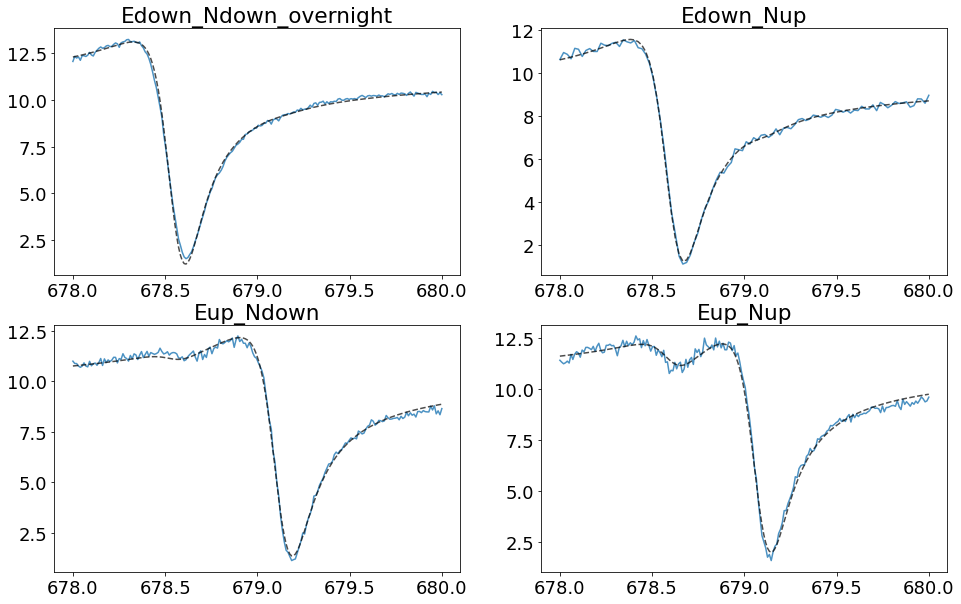

In [93]:
# Ignore the first scan as it was shorter
file_list = siv_files[1:]
model_list = [two_siv_mixed_ref] * len(file_list)
w_up_guesses = [678.476, 678.528, 679.049, 679.023]

fit_params = Parameters()
fit_params.add("w_c", value=610, vary=False)
fit_params.add("gamma_up", value=0.05, vary=False)
fit_params.add('k_in', value=99, min=10, max=356)
fit_params.add("k_tot", value=130, vary=False)

# Add in batches so that the parameters are nicely sorted
for state_idx in range(len(file_list)):
    w_up_guess = w_up_guesses[state_idx]
    fit_params.add(f"w_up_state{state_idx}", value=w_up_guess, min=w_up_guess-0.2, max=w_up_guess+0.2)
for state_idx in range(len(file_list)):
    fit_params.add(f"g_up_state{state_idx}", value=5.6, min=1, max=20)
for state_idx in range(len(file_list)):
    fit_params.add(f"A_state{state_idx}", value=10, min=1, max=40)
for state_idx in range(len(file_list)):
    fit_params.add(f"B_state{state_idx}", value=0.01, min=0.001, max=5)


combined_results_vary_ktot = fit_combined_data(fit_params, objective, model_list, file_list)
lmfit.report_fit(combined_results_vary_ktot)

###

fig, ax = plt.subplots(figsize=[16, 10], ncols=2, nrows=2)
ax = ax.flatten()

for scan_idx, filename in enumerate(file_list):
    
        siv_freqs, siv_data = collect_folder_data(scan_idx, file_list)
        ax[scan_idx].plot(siv_freqs, siv_data, alpha=0.8)
        ax[scan_idx].plot(siv_freqs, get_val_from_model(combined_results_vary_ktot.params, scan_idx, 
                                           model_list[scan_idx], siv_freqs), c='k', ls='--', alpha=0.7)
        ax[scan_idx].set_title(filename[0].split("/")[0])